# Prospective Learning: A quick introduction

Learning involves updating decision rules based on past experience to improve future performance. Probably approximately correct (PAC) learning has been
extremely useful to develop algorithms that minimize the risk—typically defined as the expected loss—on unseen samples under certain assumptions. The assumption, that samples are independent and identically distributed (IID) within the training dataset and at test time, has served us well. But it is neither testable nor believed to be true in practice. The future is always different from the past: both distributions of data and goals of the learner may change over time. Moreover, those changes may cause the optimal hypothesis to change over time as well. Although, numerous approaches have been developed to address this issue, we still lack a first-principles framework to address problems where data distributions and goals may change over time in such a way that the optimal hypothesis is time-dependent.

We have developed a theoretical framework called "Prospective Learning". Instead of data arising from an unknown probability distribution like in PAC learning, prospective learning assumes that data comes from an unknown stochastic process, that the loss considers the future, and that the optimal hypothesis may change over time. A prospective learner uses samples received up to some time $t \in \mathbb{N}$ to output an infinite sequence of predictors, which is uses for making predictions on data at all future times $t' > t$. A prospective learner minimizes the expected cumulative risk of the future using past data. To properly define such a learner, let's first define several key ingredients.

### Definitions

1. **Data**: $z_t = (x_t, y_t)$ is the datum at time $t$. Data is drawn from a stochastic process $Z \equiv (Z_t)_{t \in \mathbb{N}}$. Past data $z_{\leq t} \equiv (z_1, \dots, z_t)$, future data $z_{> t} \equiv (z_{t+1}, \dots)$

2. **Hypothesis Class**: A prospective learner selects an infinite sequence of hypotheses $h \equiv (h_1,\dots,h_t,h_{t+1},\dots) \in \mathcal{H}$

3. **Learner**: A map from past data $z_{\leq t}$ to a $h \in \mathcal{H}$

4. **Prospective Loss**: Future loss incurred by a hypothesis $h$

$$
    \bar \ell_t(h, Z) = \limsup_{\tau \to \infty} \frac{1}{\tau} \sum_{s=t+1}^{t+\tau} \ell (s, h_s(X_s), Y_s)
$$

5. **Prospective Risk**: Prospective risk at time $t$ is the expected future loss

$$
    R_t(h)
    = \mathbb{E} [ \bar \ell_t(h,Z) \mid z_{\leq  t} ]
    = \int \bar \ell_t(h,Z) \ \mathrm{d} \mathbb{P}_{Z \mid z_{\leq t}}
$$

6. **Prospective Bayes Risk**: Minimum achievable prospective risk by any learner that observes past data $z_{\leq t}$

$$
    R_t^* = \inf_{h\in \sigma(Z_{\leq t})}  R_t(h)
$$

The following schematic illustration depicts a prospective learner.

<div style="text-align: center;">
    <img src="../assets/cartoon.jpg" alt="Alt text" style="width: 30%;"/>
</div>

### A simple data generating process

Suppose there are two binary classification problems (“tasks”) where the input is one-dimensional. Inputs for both tasks are drawn from a uniform distribution
on the set $[−2, −1] \cup [1, 2]$. Ground-truth labels correspond to the sign of the input for Task 1, and the negative of the sign of the input for Task 2. Now consider a stochastic process where the task periodically alternates between task 1 and task 2, with period $= 50$.

<div style="text-align: center;">
    <img src="../assets/dp.jpg" alt="Alt text" style="width: 50%;"/>
</div>

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from dataclasses import dataclass

@dataclass
class ProcessConfig:
    """configure the data generating process"""
    period: int = 50
    seq_len: int = 2000
    num_seeds: int = 3 

class DataGeneratingProcess:
    """data generating process"""
    def __init__(self, cfg):
        self.seq_len = cfg.seq_len
        self.num_seeds = cfg.num_seeds
        self.period = cfg.period

    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 10000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(np.arange(self.seq_len))

        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {'x': xseq,
                     'y': yseq,
                     't': tseq,
                     'task': taskseq}

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)

        # generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, self.seq_len)
        x2 = np.random.uniform(1, 2, self.seq_len)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=self.seq_len)
        Xdat = x1 * mask + x2 * (1 - mask)

        # create labels
        T = self.period
        tind = np.array((np.arange(0, self.seq_len) % T) < (T // 2))
        tind = tind.astype(int)
        ind = np.where(tind == 1)[0]

        Ydat = Xdat > 0
        Ydat[ind] = Xdat[ind] < 0
        Ydat = Ydat.astype(int)

        Xdat = Xdat.reshape(-1, 1)

        return Xdat, Ydat, tind
    
    def generate_at_time(self, t, num_samples):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor
        """
        # Generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, num_samples)
        x2 = np.random.uniform(1, 2, num_samples)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=num_samples)
        Xdat = x1 * mask + x2 * (1 - mask)

        # create labels
        T = self.period
        if (t % T) < (T // 2):
            Ydat = Xdat < 0
        else:
            Ydat = Xdat > 0

        Xdat = Xdat.reshape(-1, 1)
        tdat = t * np.ones(num_samples)

        x = torch.from_numpy(Xdat).float()
        y = torch.from_numpy(Ydat).long()
        t = torch.from_numpy(tdat).float()
        return x, y, t
    
class SyntheticDataset(Dataset):
    """Form the torch dataset"""
    def __init__(self, data, idx, run_id, test):
        self.x = torch.from_numpy(data['x']).float()
        self.y = torch.from_numpy(data['y']).long()
        self.t = torch.from_numpy(data['t']).float()

        if test:
            # Use data from time 'idx' onwards for testing
            self.x = self.x[run_id, idx:]
            self.y = self.y[run_id, idx:]
            self.t = self.t[run_id, idx:]
        else:
            # Use data up to time 'idx' onwards for training
            self.x = self.x[run_id, :idx]
            self.y = self.y[run_id, :idx]
            self.t = self.t[run_id, :idx]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t

### A simple prospective learner

Theorem 1 of our works states that a learner that minimizes empirical prospective risk over a class consisting of infinite sequence of hypotheses is a strong prospective learner. We denote this learner by "prospective empirical risk minimizer" or "prospective ERM". In other words, we have to minimize the prospective risk over a sequence of predictors indexed by time. We construct a sequence of predictors by incorporating time as an additional input to a multi-layer perceptron (MLP). For frequencies $\omega_i = \pi/i$ for $i = 1, \dots, d/2$, we obtain a $d$-dimensional embedding of time $t$ as $\varphi(t) = (\sin(\omega_1 t), \dots, \sin(\omega_{d/2} t), \cos(\omega_1 t), \dots, \cos(\omega_{d/2} t))$. A predictor $h_t(\cdot)$ uses a MLP that takes as input, an embedding of time $\varphi(s)$, and the input $x_s$ to predict the output $y_s$ for any time $s \in \mathbb{N}$. Using
such an embedding of time is useful in prospective learning because, then, one need not explicitly maintain the infinite sequence of predictors $h \equiv (h_1, \dots)$.

<div style="text-align: center;">
    <img src="../assets/perm.jpg" alt="Alt text" style="width: 25%;"/>
</div>

We implement this simple prospective learer as follows.

In [ ]:
import torch.nn as nn

class TimeEmbedding(nn.Module):
    """form the time-embedding"""
    def __init__(self, tdim=10):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2).unsqueeze(0)

    def forward(self, t):
        sin_emb = torch.sin(self.freqs.to(t.device) * t)
        cos_emb = torch.cos(self.freqs.to(t.device) * t)
        return torch.cat([sin_emb, cos_emb], dim=-1)
    
class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, in_dim=1, out_dim=2, hidden_dim=32, tdim=50, prospective=False):
        super(MLP, self).__init__()
        self.prospective = prospective
        if prospective:
            self.time_embed = TimeEmbedding(tdim=tdim)
            self.fc1 = nn.Linear(in_dim + tdim, hidden_dim)
        else:
            self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, t):
        if self.prospective:
            t = self.time_embed(t.unsqueeze(-1))
            x = torch.cat([x, t], dim=-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

We use the zero-one error to calculate prospective risk. In this notebook, we only consider two learners. First is a simple MLP, which outputs a single fixed predictor over all times after being trained on the past data. Second is a prospective MLP, which outputs a time-varying predictor that consumes both the time and the input. 

We generate a sequence of 2000 samples from the data generating process. The learners are trained on the data from the first $t$ time steps ($z_{\leq t}$). Next we compute the instantaneous loss (loss of the predictor at time $t$) and prospective loss (average loss of the predictor over the future samples $z_{>t}$). We repeat this procedure over 3 random seeds to obtain estimates for instantaneous risk and prospective risk at time $t$.

Let's write a trainer class to train our models, and several helper functions to set random seeds and obtain data loaders.

In [ ]:
import random

def set_seed(acorn):
    """set random seed"""
    random.seed(acorn)
    np.random.seed(acorn)
    torch.manual_seed(acorn)
    torch.cuda.manual_seed(acorn)
    torch.cuda.manual_seed_all(acorn)

def get_dataloaders(dp, t, seed):
    """obtain the dataloaders"""
    train_dataset = SyntheticDataset(dp.data, t, seed, test=False)
    test_dataset = SyntheticDataset(dp.data, t, seed, test=True)
    ttest_dataset = TensorDataset(*dp.generate_at_time(t, 500))
    trainloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader, ttestloader

class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, test_loader, ttest_loader, criterion, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.ttest_loader = ttest_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            x, y, t = batch
            outputs = self.model(x, t)

            loss = self.criterion(outputs.squeeze(), y)

            self.optimizer.zero_grad()  
            loss.backward()            
            self.optimizer.step() 

            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def evaluate(self):
        self.model.eval()
        errs = []
        with torch.no_grad():
            for batch in self.test_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                errs.append(err.cpu().numpy())
        ploss = np.concatenate(errs).mean()

        errs = []
        with torch.no_grad():
            for batch in self.ttest_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                errs.append(err.cpu().numpy())
        iloss = np.concatenate(errs).mean()
        return iloss, ploss

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch()
            if self.verbose:
                print(f'Epoch [{epoch + 1}/{num_epochs}], '
                    f'Train Loss: {train_loss:.4f}, ')
        print(f"training loss at last epoch: {train_loss:.3f}")

We have all the ingredients to run our experiment now. The code snippet below will train the 
predictors for at a series of $t$ values and evaluate both prospective and instantaneous risks. 
It takes about 7mins to run this cell on a CPU.

In [ ]:
# configure and obtain the data generating process
cfg = ProcessConfig(
    period=50,
    seq_len=2000,
    num_seeds=3,
)
dp = DataGeneratingProcess(cfg)
dp.generate_data()

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# methods being considered
methods = ["MLP", "Prospective-MLP"]

t_list = np.arange(50, 600, 5) # list of time steps 
instant_risk = {method: [] for method in methods} # store instant risk
prospective_risk = {method: [] for method in methods} # store prospective risk

# run experiment
for t in t_list:
    instant_loss = {method: [] for method in methods}
    prospective_loss = {method: [] for method in methods}
    print(f"time t = {t}")

    for seed in range(cfg.num_seeds):
        print(f"seed = {seed}")
        acorn = seed * 1000 + 1996
        set_seed(acorn)
        
        trainloader, testloader, ttestloader = get_dataloaders(dp, t, seed)
        
        for method in methods:
            prospective = True if "Prospective" in method else False
            model = MLP(prospective=prospective)
            model.to(device)

            optimizer = torch.optim.SGD(
                model.parameters(), lr=0.1,
                momentum=0.9, nesterov=True,
                weight_decay=0.00001)
            criterion = nn.CrossEntropyLoss()

            trainer = Trainer(model, trainloader, testloader, ttestloader, criterion, optimizer, device)
            trainer.train(num_epochs=100)
            iloss, ploss = trainer.evaluate()

            instant_loss[method].append(iloss)
            prospective_loss[method].append(ploss)
    
    for method in methods:
        instant_risk[method].append(np.mean(instant_loss[method]))
        prospective_risk[method].append(np.mean(prospective_loss[method]))

In [ ]:
# save the results
import pickle
results = {
    "prisk": prospective_risk, 
    "irisk": instant_risk
}
with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)

Finally, we plot the instantaneous and prospecitve risks against the times $t$. 

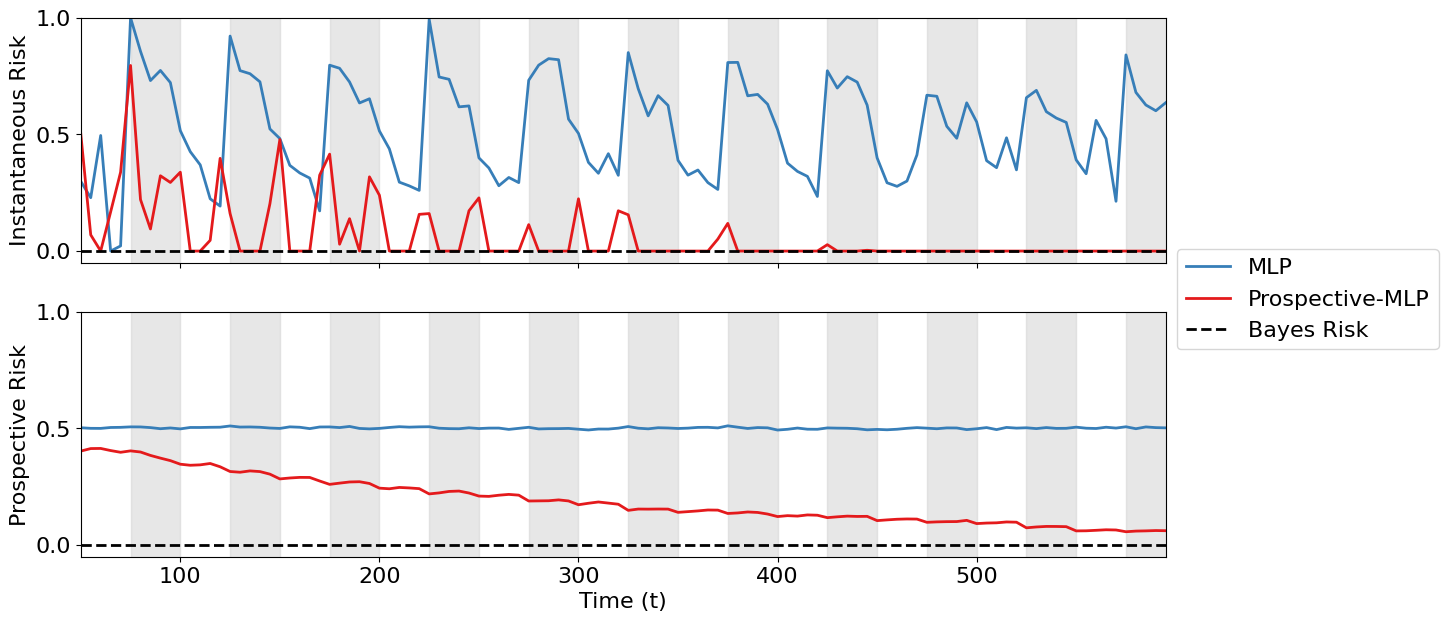

In [178]:
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
colors = ['#377eb8', '#e41a1c']

for i, method in enumerate(methods):
    ax = axes[0]
    ax.plot(t_list, instant_risk[method], color=colors[i], lw=2, label=method)
    ax.set_ylabel("Instantaneous Risk")
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1])
    ax.set_xlim([t_list[0], t_list[-1]])

    ax = axes[1]
    ax.plot(t_list, prospective_risk[method], color=colors[i], lw=2)
    ax.set_ylabel("Prospective Risk")
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1])
    ax.set_xlim([t_list[0], t_list[-1]])

    ax.set_xlabel("Time (t)")

T = 25
for i in range(50, 600, T*2):
    task_start = i + T
    task_end = i + 2 * T
    for j in range(0, 2):
        ax = axes[j]
        ax.fill_betweenx([-0.1, 1.1], task_start, task_end, color='lightgray', alpha=0.3)
        ax.fill_betweenx([-0.1, 1.1], task_start, task_end, color='lightgray', alpha=0.3)
        
for j in range(0, 2):
    ax = axes[j]
    ax.plot(t_list, np.zeros_like(t_list), lw=2, ls='dashed', color='k', label="Bayes Risk")

ax = axes[0]
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.1))
plt.show()

By construction, this data generating process induces a time-variant optimal decision boundary that switches every 25 time steps. 
However, MLP only outputs a single fixed predictor at each time $t$, and as a result it fails to achieve a good prospective risk. In fact,
it is not able to do better than random guessing even after observing a large amount of data. Notice that the instantenous risk of the MLP 
surges when the distribution swicthes from task 1 to task 2. On other the other hand, we can see that the prospective-MLP achieves a 
good instantaneous and prospective risk as it observed more data from the process. 